# An Analytical Model of the Lifecycle of Tropical Anvil Cloud Radiative Effects
Nick Lutsko (SIO/UCSD). Last updated: 11/12/2025

We want a simple model of high anvil clouds that explains why their net CRE is small. To do this, we will combine simple models of (1) cloud radiative effects, (2) cloud spreading, and (3) cloud microphysics. To tune the models we have data from some RRTMG calculations (from Casey) and from a Cloud Resolving Model (CRM) simulation with an age tracer (from Blaz). Once the models are tuned we can use them to do sensitivity tests to try to say something about cloud feedbacks and sources of model biases.

## (1) CRE parameterization

Our first step is to parameterize the CREs as a function of cloud optical depth, which is in turn proportional the cloud condensate mixing ratio. It's easy to do this for the LW CRE, but we need to use the two-stream equations to get a parameterization for the SW CRE.

### LW CRE
The LW CRE is:
\begin{align}
CRE_{\text{LW}} &= -\epsilon \sigma(T_\text{c}^4  - T_0^4),
\end{align}
where $\epsilon$ is the cloud emissivity, $\sigma$ is the Stefan-Boltzmann constant, $T_c$ is the cloud temperature and $T_0$ is the clear-sky emission temperature.

We now assume cloud temperature is fixed, and that the LW emissivity $\epsilon = 1 - e^{-\tau_{\text{c,LW}}/\mu_\text{LW}} = 1 - e^{-\gamma\tau_{\text{c,SW}}/\mu_\text{LW}}$, where $\mu_\text{LW}$ is the cosine of the LW zenith angle ($\theta_{\text{LW}}$), $\tau_{c,SW}$ is the total SW cloud optical depth and $\gamma$ is a constant relating the SW and LW cloud optical depths (we want to write everything in terms of $\tau_{c,SW}$). This gives:
\begin{align}
CRE_{LW} = -(1 - e^{-\gamma\tau_{c,SW}/\mu_L}) \sigma (T_c^4  - T_0^4),
\end{align}
and a tendency of
\begin{align}
\frac{dCRE_{\text{LW}}}{dt} = -\frac{\gamma}{\mu_\text{LW}}\frac{d\tau_{\text{c,SW}}}{dt}e^{-\gamma\tau_{\text{c,SW}}/\mu_\text{L}}\sigma(T_\text{c}^4  - T_0^4).
\end{align}


### SW CRE
The SW CRE is given by:
\begin{align}
CRE_{\text{SW}} &= -Q_\text{S}(\alpha_\text{c} - \alpha_0),
\end{align}
where $Q_\text{S}$ is the insolation, $\alpha_\text{c}$ is the cloud albedo and $\alpha_0$ is the clear-sky albedo. For simplicity, we assume the surface albedo beneath the clouds is zero -- it doesn't materially affect the derivation, but adds an extra term.

After working with the two-stream equations, we can (eventually) rewrite this in terms of $\tau_{c,SW}$:
\begin{align}
\text{CRE}_\text{SW} &= -\text{Q}_\text{S}\left(\frac{1}{1 + \frac{\mu_\text{SW}}{\beta(\mu_\text{SW})\tau_\text{c,SW}}} - \alpha_0\right),
\end{align}
with tendency:
\begin{align}
\frac{dCRE_{\text{SW}}}{dt} = -Q_\text{S}\left(\alpha_\text{c}(1 - \alpha_\text{c})\left(\frac{dln(\tau_{\text{c,SW}})}{dt} + \frac{dln(\beta)}{dt}\right) - \frac{\alpha_\text{c}^2}{\beta(\mu_\text{SW})\tau_{\text{c,SW}}}\frac{d\mu_\text{SW}}{dt}\right)
 - \frac{dQ_\text{S}}{dt}(\alpha_\text{c} - \alpha_0).
\end{align}


where $Q_S$ is the insolation, $\mu_{SW}$ is the cosine of the SW zenith angle, $\beta$ is the back-scattered fraction, $\tau_{c,SW}$ is total SW cloud optical depth and $\alpha_0$ is the clear-sky albedo. Note that the cloud albedo is:
\begin{align}
\alpha_c(\tau_c, \mu_S) = \frac{\beta(\mu_S)\tau_{c,SW}}{\mu_S + \beta(\mu_S)\tau_{c,SW}} = \frac{1}{1 + \frac{\mu_S}{\beta(\mu_S)\tau_{c,SW}}}.
\end{align}

Let's test these LW and SW CRE against some RRTMG data

In [47]:
#First load the modules we'll need
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import xarray as xr
import scipy.interpolate as si
%matplotlib inline

In [48]:
#physical parameters we'll be using 
rho_air = 0.3                 # air density [kg m^-3]
rho_ice = 917.0               # ice density [kg m^-3]
sigma = 5.67e-8               # Stefan-Boltzmann constant [W m^-2 K^-4]
Gamma = 9.8 / 1000.0          # lapse rate [K m^-1]
lw_mu = 0.6                   # LW zenith-angle factor [-]

In [49]:
#open RRTMG datasets
ds = xr.open_dataset("data/TOA_fluxes_tropical_ice_cloud_RRTMG.nc")
#calculations with varied insolation
ds2 = xr.open_dataset("data/TOA_fluxes_tropical_ice_cloud_RRTMG_vary_insolation.nc")

In [50]:
Qs = 0.4 #daily-mean
RRTM_SWCRE = Qs * (ds.uflx_sw_TOA[:] - ds.uflxc_sw_TOA[:])
RRTM_LWCRE = ds.uflx_lw_TOA - ds.uflxc_lw_TOA
RRTM_net = RRTM_SWCRE + RRTM_LWCRE

RRTM_SWCRE2 = (ds2.uflx_sw_TOA[:] - ds2.uflxc_sw_TOA[:])
RRTM_LWCRE2 = ds2.uflx_lw_TOA - ds2.uflxc_lw_TOA
RRTM_net2 = RRTM_SWCRE2 + RRTM_LWCRE2

In [51]:
#Estimate gamma using values in Fu [1996] (SW) and Fu et al [1998] (LW)
def LW_absorb(b_0, b_1, b_2, b_3, D):
    #equation 3.2
    return (b_0 + b_1 * D + b_2 * D**2 + b_3 * D ** 3) / D

def SW_extinct(a_0, a_1, D):
    #equation 3.9a
    return (a_0 + a_1 / D)

#grabbed these from the paper
LW_9 = LW_absorb(0.547, 0.0195, -2.085 * 10. ** -4, 7.5634 * 10. ** -7., 46.01)
LW_10 = LW_absorb(0.5187942, 0.01993425, -2.071124 * 10. ** -4, 7.378074 * 10. ** -7., 46.01)
SW_048 = SW_extinct(-0.945 * 10. ** -4., 2.52 , 46.01)
SW_052 = SW_extinct(-0.303 * 10. ** -4., 2.51805 , 46.01)

gamma = (LW_9 + LW_10)/(SW_048 + SW_052)
print(gamma, 1. / gamma)

0.426419650789058 2.345107684764466


In [52]:
#make optical depths
re = float(ds.Re_ice) * 10. ** -6. #ice radii
tau = 3./2. * ds.IWP / 1000. / rho_ice / re #our estimate of tau
l = len(tau) #number of \tau intervals
n = len(ds.SZA[:]) #number of zenith angles

sza = 30 #sza to compare with
mu = np.cos(ds.SZA[:] * np.pi / 180.) #cosine SW zenith angles

Start with the LW CRE, which is easier

In [53]:
#Calculate initial cloud temperature
Tcc = (ds.uflx_lw_TOA[-1] / sigma / (1. - np.exp(-gamma * tau[-1] / 0.6))) ** (1. / 4.)

#Calculate clear-sky radiating temperature
To = (ds.uflxc_lw_TOA / sigma) ** (1. / 4.)
print("cloud temp:", float(Tcc))
print("clear-sky radiating temp:", float(To))

#Now calculate lw CRE and emissivity
lw_cre = (1. - np.exp(-gamma * tau / lw_mu )) * sigma * (Tcc ** 4 - To ** 4)
lw_cre = np.asarray(lw_cre[:, 0])
emissivity = 1. - np.exp(-gamma * tau / lw_mu)

cloud temp: 221.18883997935208
clear-sky radiating temp: 266.8946845564665


Now we're going to calculate the albedo, hence the SW CRE. The key tuning parameter is $\beta$, and we'll tune the model in 3 ways: 
with constant $\beta$, $\beta(\theta)$ and full $\beta$ 

In [54]:
#fix beta at \theta = 30, max(tau)
albedo1 = np.zeros((n, l))
albedo0 = ds.uflx_sw_TOA[sza, -1] / ds.dflx_sw_TOA
albedo1[:, -1] = albedo0 * np.ones(n)
beta1 = albedo1[0, -1] * float(mu[30]) / (float(tau[-1]) * (1. - albedo1[0, -1]))
print("Fixed beta value:", beta1)
albedo1[:, :-1] = beta1 * np.expand_dims(tau[:-1], 0) / (np.expand_dims(mu, 1) + beta1 * np.expand_dims(tau[:-1], 0))

#beta(\theta)
albedo2 = np.zeros((n, l))

#assume beta from \tauc = 15ish
target_tau = 15
tc = np.abs(tau - target_tau).argmin()
print("Tuning cloud optical depth:", tau[tc])
albedo0 = ds.uflx_sw_TOA[:, tc] / ds.dflx_sw_TOA
beta2 = albedo0 * mu[:] / (float(tau[tc]) * (1. - albedo0))
albedo2[:, :] = np.expand_dims(beta2, 1) * np.expand_dims(tau[:], 0) / (np.expand_dims(mu, 1) + np.expand_dims(beta2, 1) * np.expand_dims(tau[:], 0))

#Full beta
albedo3 = ds.uflx_sw_TOA[:, :] / ds.dflx_sw_TOA
beta3 = albedo3 * np.expand_dims(mu, 1) / (np.expand_dims(tau, 0) * (1. - albedo3))

Fixed beta value: 0.026975205852069594
Tuning cloud optical depth: <xarray.DataArray 'IWP' ()> Size: 8B
array(14.48248519)
Coordinates:
    IWP      float64 8B 265.6


In [55]:
#Now calculate the SW CREs
cs_alb = 0.07 #ask Casey to rerun with this set to 0
sw_cre = np.expand_dims(ds.dflx_sw_TOA, 1) * (albedo1 - cs_alb)
sw_cre2 = np.expand_dims(ds.dflx_sw_TOA, 1) * (albedo2 - cs_alb)
sw_cre3 = np.expand_dims(ds.dflx_sw_TOA, 1) * (albedo3 - cs_alb)

### Main plots

Now we can plot! Don't show it here, but I have the same kind of plot for the constant $\beta$ parameterization

In [56]:
# Generate a colormap from dark brown to yellow for plotting sensitivity tests
cmap = mcolors.LinearSegmentedColormap.from_list("brown_yellow", ["#5D4037", "#FFEB3B"])
cmap2 = plt.cm.cividis

<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:86: SyntaxWarning: invalid escape sequence '\c'
<>:87: SyntaxWarning: invalid escape sequence '\c'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:86: SyntaxWarning: invalid escape sequence '\c'
<>:87: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/1031029781.py:69: SyntaxWarning: invalid escape sequence '\m'
  plt.title("d) $\mu_{SW}$", loc = "left")
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/1031029781.py:86: SyntaxWarning: invalid escape sequence '\c'
  plt.text(7., -200, "$\\theta_{SW} = 0^\circ$")
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/1031029781.py:87: SyntaxWarning: invalid escape sequence '\c'
  plt.text(40., 150, "$\\theta_{SW} = 80^\circ$")


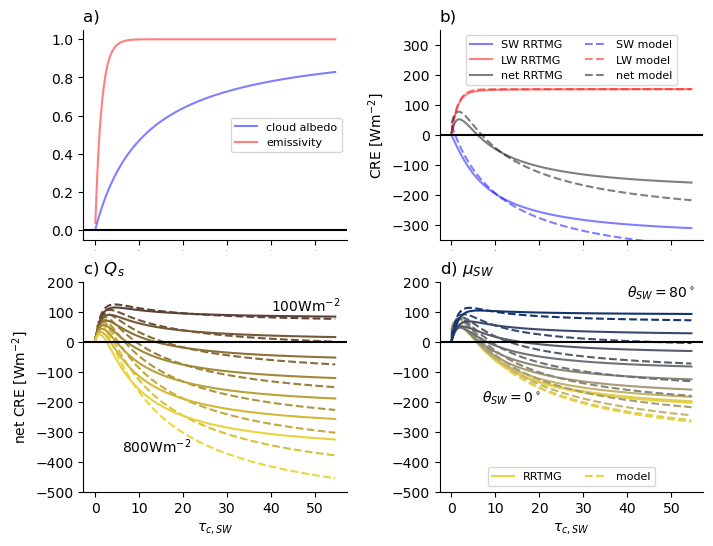

In [57]:
#######Figure 1 of main text############

#beta is a function of \mu only
fig = plt.figure(figsize = (8, 6))
plt.subplots_adjust(hspace = 0.2, wspace = 0.35)

ax = plt.subplot(2, 2, 1)
plt.title("a)", loc = "left")
plt.plot(tau, albedo2[sza], 'b', alpha = 0.5)
plt.plot(tau, emissivity, 'r', alpha = 0.5)

#plt.xlabel("$\\tau$")
plt.legend(["cloud albedo", "emissivity"], loc = "center right", fontsize = 8)
plt.axhline(y = 0, color = 'k')

plt.ylim([-0.05, 1.05])
plt.xticks(fontsize = 0)
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(2, 2, 2)
plt.title("b)", loc = "left")

plt.plot(tau, -RRTM_SWCRE[sza], 'b', alpha = 0.5)
plt.plot(tau, -RRTM_LWCRE, 'r', alpha = 0.5)
plt.plot(tau, -RRTM_net[sza], 'k', alpha = 0.5)

plt.plot(tau, -sw_cre2[sza] * .4, 'b--', alpha = 0.5)
plt.plot(tau, -lw_cre, 'r--', alpha = 0.5)
plt.plot(tau, -lw_cre - sw_cre2[sza] * .4, 'k--', alpha = 0.5)

plt.axhline(y = 0, color = 'k')
plt.legend(["SW RRTMG", "LW RRTMG", "net RRTMG", "SW model", "LW model", "net model"], loc = "upper center", ncol = 2, fontsize = 8)

plt.xticks(fontsize = 0)
plt.ylabel("CRE [Wm$^{-2}$]")
ax.spines[['right', 'top']].set_visible(False)

plt.ylim([-350., 350.])

#Vary insolation
new_Qsd = np.arange(100., 900., 100.) #daily-averaged insolation
new_sw_cre = np.zeros( (len(new_Qsd), len(tau)))
for i in range(len(new_Qsd)):
    new_sw_cre[i] = new_Qsd[i] * (albedo2[sza] - cs_alb)
new_sw_cre[new_sw_cre < 0.] = 0.

ax = plt.subplot(2, 2, 3)
plt.title("c) $Q_s$", loc = "left")
for i in range(len(new_Qsd)):
    color = cmap(i / len(new_Qsd))  # Get color from colormap
    plt.plot(tau, -lw_cre - new_sw_cre[i], '--', color = color) #plot net CRE

for i in range(7):
    color = cmap(i / 7)  # Get color from colormap
    plt.plot(ds2.COT_SW[:], -RRTM_net2[20 * i, :], color = color)

plt.axhline(y = 0, color = 'k')

plt.text(40., 100, "100Wm$^{-2}$")
plt.text(6., -370, "800Wm$^{-2}$")

plt.xlabel("$\\tau_{c, SW}$")
plt.ylabel("net CRE [Wm$^{-2}$]")
ax.spines[['right', 'top']].set_visible(False)

plt.ylim([-500., 200.])

ax = plt.subplot(2, 2, 4)
plt.title("d) $\mu_{SW}$", loc = "left")

new_sw_cre3 =  np.expand_dims(ds.dflx_sw_TOA, 1) * (albedo2 - cs_alb) * .4
plt.plot(tau, -RRTM_net[0], '-', color=color) #plot net CRE
plt.plot(tau, -new_sw_cre3[0] - lw_cre, '--', color=color) #plot net CRE

plt.legend(["RRTMG", "model"],ncol = 2, loc = "lower center", fontsize = 8)

for i in range(1, 9):
    color = cmap2(1 - i/9)  # Get color from colormap
    plt.plot(tau, -new_sw_cre3[i * 10] - lw_cre, '--', color=color) #plot net CRE
    plt.plot(tau, -RRTM_net[i * 10], '-', color=color) #plot net CRE

plt.axhline(y = 0, color = 'k')
plt.xlabel("$\\tau_{c, SW}$")

ax.spines[['right', 'top']].set_visible(False)
plt.text(7., -200, "$\\theta_{SW} = 0^\circ$")
plt.text(40., 150, "$\\theta_{SW} = 80^\circ$")
plt.ylim([-500., 200.])

plt.savefig("images/high_cloud_CRE_lwsw_varybeta.png")
plt.savefig("images/high_cloud_CRE_lwsw_varybeta.pdf")

<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\c'
<>:88: SyntaxWarning: invalid escape sequence '\c'
<>:70: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\c'
<>:88: SyntaxWarning: invalid escape sequence '\c'
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/4292110185.py:70: SyntaxWarning: invalid escape sequence '\m'
  plt.title("d) $\mu_{SW}$", loc = "left")
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/4292110185.py:87: SyntaxWarning: invalid escape sequence '\c'
  plt.text(7., -200, "$\\theta_{SW} = 0^\circ$")
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/4292110185.py:88: SyntaxWarning: invalid escape sequence '\c'
  plt.text(40., 150, "$\\theta_{SW} = 80^\circ$")


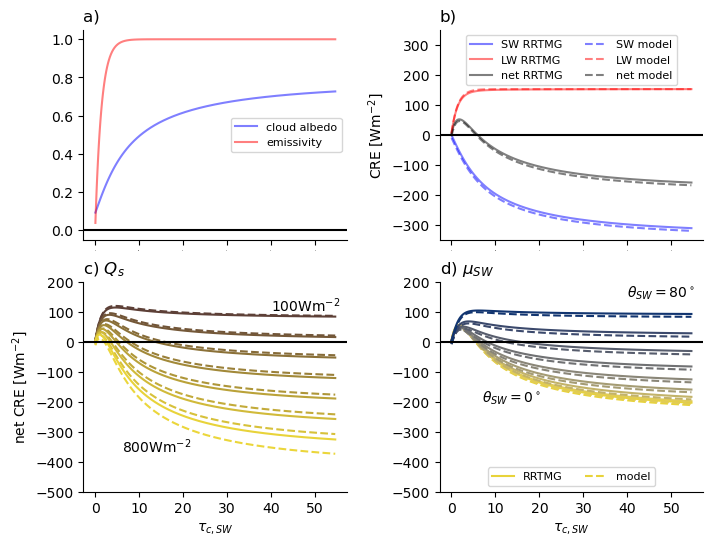

In [58]:
#######Supplementary Figure S2############

#Full \beta
fig = plt.figure(figsize = (8, 6))
plt.subplots_adjust(hspace = 0.2, wspace = 0.35)

ax = plt.subplot(2, 2, 1)
plt.title("a)", loc = "left")
plt.plot(tau, albedo3[sza], 'b', alpha = 0.5)
plt.plot(tau, emissivity, 'r', alpha = 0.5)

#plt.xlabel("$\\tau$")
plt.legend(["cloud albedo", "emissivity"], loc = "center right", fontsize = 8)
plt.axhline(y = 0, color = 'k')

plt.ylim([-0.05, 1.05])
plt.xticks(fontsize = 0)
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(2, 2, 2)
plt.title("b)", loc = "left")

plt.plot(tau, -RRTM_SWCRE[sza], 'b', alpha = 0.5)
plt.plot(tau, -RRTM_LWCRE, 'r', alpha = 0.5)
plt.plot(tau, -RRTM_net[sza], 'k', alpha = 0.5)

plt.plot(tau, -sw_cre3[sza] * .4, 'b--', alpha = 0.5)
plt.plot(tau, -lw_cre, 'r--', alpha = 0.5)
plt.plot(tau, -lw_cre - sw_cre3[sza] * .4, 'k--', alpha = 0.5)

plt.axhline(y = 0, color = 'k')
plt.legend(["SW RRTMG", "LW RRTMG", "net RRTMG", "SW model", "LW model", "net model"], loc = "upper center", ncol = 2, fontsize = 8)

plt.xticks(fontsize = 0)
plt.ylabel("CRE [Wm$^{-2}$]")
ax.spines[['right', 'top']].set_visible(False)

plt.ylim([-350., 350.])

#Vary insolation
new_Qsd = np.arange(100., 900., 100.) #daily-averaged insolation
new_sw_cre = np.zeros( (len(new_Qsd), len(tau)))
for i in range(len(new_Qsd)):
    new_sw_cre[i] = new_Qsd[i] * (albedo3[sza] - cs_alb)
new_sw_cre[new_sw_cre < 0.] = 0.

ax = plt.subplot(2, 2, 3)
plt.title("c) $Q_s$", loc = "left")
for i in range(len(new_Qsd)):
    color = cmap(i / len(new_Qsd))  # Get color from colormap
    plt.plot(tau, -lw_cre - new_sw_cre[i], '--', color = color) #plot net CRE

for i in range(7):
    color = cmap(i / 7)  # Get color from colormap
    plt.plot(ds2.COT_SW[:], -RRTM_net2[20 * i, :], color = color)


plt.axhline(y = 0, color = 'k')

plt.text(40., 100, "100Wm$^{-2}$")
plt.text(6., -370, "800Wm$^{-2}$")

plt.xlabel("$\\tau_{c, SW}$")
plt.ylabel("net CRE [Wm$^{-2}$]")
ax.spines[['right', 'top']].set_visible(False)

plt.ylim([-500., 200.])

ax = plt.subplot(2, 2, 4)
plt.title("d) $\mu_{SW}$", loc = "left")

new_sw_cre3 =  ds.dflx_sw_TOA * (albedo3 - cs_alb) * .4
plt.plot(tau, -RRTM_net[0], '-', color=color) #plot net CRE
plt.plot(tau, -new_sw_cre3[0] - lw_cre, '--', color=color) #plot net CRE

plt.legend(["RRTMG", "model"],ncol = 2, loc = "lower center", fontsize = 8)

for i in range(1, 9):
    color = cmap2(1 - i/9)  # Get color from colormap
    plt.plot(tau, -new_sw_cre3[i * 10] - lw_cre, '--', color=color) #plot net CRE
    plt.plot(tau, -RRTM_net[i * 10], '-', color=color) #plot net CRE

plt.axhline(y = 0, color = 'k')
plt.xlabel("$\\tau_{c, SW}$")

ax.spines[['right', 'top']].set_visible(False)
plt.text(7., -200, "$\\theta_{SW} = 0^\circ$")
plt.text(40., 150, "$\\theta_{SW} = 80^\circ$")
plt.ylim([-500., 200.])

plt.savefig("images/high_cloud_CRE_lwsw_rrtmg.png")
plt.savefig("images/high_cloud_CRE_lwsw_rrtmg.pdf")

### Supporting plots

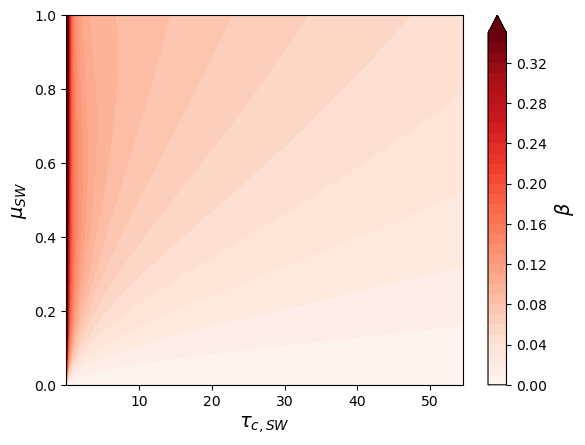

In [59]:
####### Figure 2 of main text############

#plot all betas
plt.contourf(tau, np.cos(ds.SZA * np.pi / 180.), beta3, levels = np.arange(0., 0.36, 0.01), extend="max", cmap = plt.cm.Reds)
cset = plt.colorbar()
cset.set_label("$\\beta$", fontsize = 14)
plt.xlabel("$\\tau_{c,SW}$", fontsize = 14)
plt.ylabel("$\\mu_{SW}$", fontsize = 14)

plt.savefig("images/complete_beta.pdf")
plt.savefig("images/complete_beta.png")

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/925688592.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu_{SW}$", fontsize = 14)


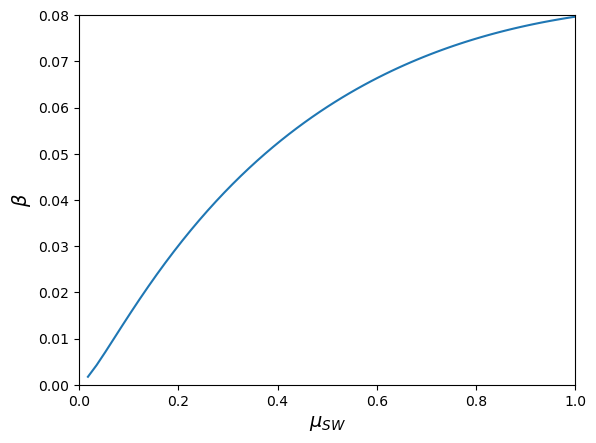

In [60]:
#######Supplementary Figure S1############

#plot \beta for tauc = 15
mu = np.cos(ds.SZA * np.pi / 180.)
plt.plot(mu[:-1], beta3[:-1, tc])
plt.xlabel("$\mu_{SW}$", fontsize = 14)
plt.ylabel("$\\beta$", fontsize = 14)

plt.xlim([0., 1.])
plt.ylim([0., 0.08])

plt.savefig("images/beta_tauc15.png")
plt.savefig("images/beta_tauc15.pdf")

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/2029475403.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu_{SW}$", fontsize = 14)


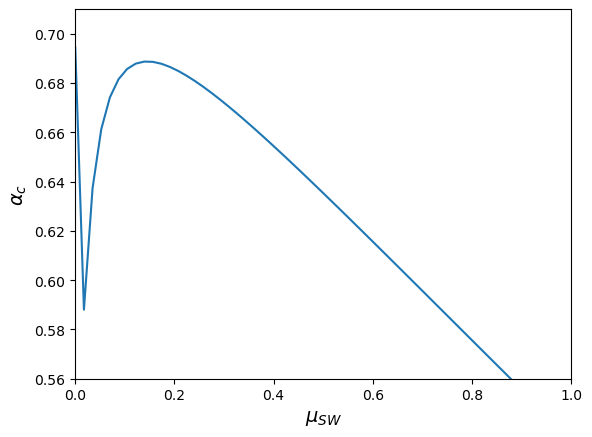

In [61]:
#######Supplementary Figure S3############

#plot albedo from RRTMG to show non-monotonicity
albedo = ds.uflx_sw_TOA[:, tc] / ds.dflx_sw_TOA #albedo for optical depth of 15
plt.plot(mu[:], albedo[:])

plt.xlabel("$\mu_{SW}$", fontsize = 14)
plt.ylabel("$\\alpha_c$", fontsize = 14)

plt.xlim([0., 1.])
plt.ylim([0.56, 0.71])

plt.savefig("images/albedo.png")
plt.savefig("images/albedo.pdf")

## (2) Cloud Spreading Model

Now we move on to the cloud spreading model, which combines spreading due to the initial convective KE with a constant radiatively-driven spreading rate.

We model anvils as disks of radius $r$ and depth $h$. The KE of an anvil disk is
\begin{align}
KE(t) = \pi\rho h r(t)^2\frac{v(t)^2}{2},
\end{align}
where $\rho$ is the air density and $v$ represents a typical eddy velocity for small-scale turbulence in the cloud. We relate $v$ to the spreading rate by a (unitless) constant: $u \equiv dr/dt = cv$, and continue to hold $h$ constant, as well as $\rho$.

Rather than being conserved, as in [Seeley et al. (2019)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018GL080747), we assume the KE of the initial outflow decays exponentially due to turbulent dissipation, small-scale mixing and gravity wave propagation:
\begin{align}
\label{eq:ke_dt}
\frac{dKE(t)}{dt} = -a KE(t),
\end{align}
where $a$ is a decay constant (s$^{-1}$). This is a first-order ODE, and can be solved to give:
\begin{align}
KE(t) = KE_0e^{-at}, \notag
\end{align}
where the initial kinetic energy $KE_0 = \pi\rho h r_0^2\frac{v_0^2}{2}$. Re-arranging and substituting $u$ for $v$, we obtain a KE-driven spreading rate
\begin{align}
u_\text{KE}(t) = c\frac{r_0v_0}{r_{KE}(t)}e^{-at / 2}.
\end{align}
Following [Seeley et al. (2019)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018GL080747), we define the constant $b^{-1} = r_0 / (2cv_0)$, which is the initial doubling time of the cloud radius and allows us to rewrite the spreading rate as:
\begin{align}
\label{eq:ke_spread}
u_\text{KE}(t) = \frac{br_0^2}{2r_{KE}(t)}e^{-a t / 2}.
\end{align}
We now multiply across by $r$ and write out the spreading rate explicitly:
\begin{align}
r_{KE}(t)\frac{dr_{KE}(t)}{dt} = \frac{br_0^2}{2}e^{-a t / 2}, \notag
\end{align}
then integrate both sides to obtain:
\begin{align}
r_\text{KE}(t) = r_0\sqrt{1 + \frac{2b}{a}(1 - e^{-a t / 2})}.
\end{align}

For the radiatively-driven component, we assume a constant spreading rate $u_\text{R} = u_\text{R0}$, so $r(t) = r_0 + u_\text{R0}t$. This assumption is supported by the ``isolated cloud" experiment in [Gasparini et al. (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS001736), in which clouds without any initial KE spread at a nearly constant rate for hours $\sim$1-7 (see their Figure 9), and by the radiatively-forced circulations of [Durran al. (2009)](https://atmos.washington.edu/~ackerman/Articles/Durran_TTLcirrus_AMS.pdf), who found that after a spin-up period proportional to aspect ratio, spreading rates approach a steady value for fixed heating. Scaling their 15-20 hour spin-up time for 100 km-scale cirrus to 10 km-scale anvil outflows yields a spin-up time of order 1 hour, consistent with the fast adjustment times in our model.

Heuristically, we can explain the constant radiatively-driven spreading by combining Weak Temperature Gradient balance and the continuity equation. We write WTG balance for radiatively-driven circulations in the cloud as:
\begin{align}
w_\text{R} = \frac{Q_\text{R}}{c_\text{p}d\theta/dz}, \notag
\end{align}
where $w_\text{R}$ is the radiatively-driven vertical velocity, $Q_\text{R}$ is the in-cloud radiative cooling, $c_\text{p}$ is the heat capacity of dry air, and $d\theta/dz$ is the background stratification. We write the continuity equation for 2D flow as:
\begin{align}
\frac{w_\text{R}}{H} \approx \frac{u_\text{R}}{D}, \notag
\end{align}
where $D$ and $H$ are the horizontal and vertical length-scales of the circulation (not necessarily equal to the cloud-disk dimensions), and $u_\text{R}$ is the radiatively-driven horizontal velocity, which we equate with the spreading rate. Substituting for $w_\text{R}$ and re-arranging then gives an estimate for the spreading rate:
\begin{align}
u_\text{R} = \frac{D}{H}\frac{Q_\text{R}}{c_\text{p}d\theta/dz}.
\end{align}
A constant $u_\text{R}$ could thus arise from compensation between the increasing horizontal scale of the flow (larger $D$) and decreasing $Q_\text{R}$ as the cloud thins. 

We represent the eventual decay of radiatively-driven spreading by a smooth hyperbolic-tangent taper:
\begin{align}
u_\text{R}(t) = \frac{u_\text{R0}}{2}\left(1 + \text{tanh}\left(\frac{t_\text{d} - t}{\Delta}\right)\right),
\end{align}
where $t_\text{d}$ marks the onset of decay and $\Delta$ sets the timescale of the transition. Hence the radiatively-driven spreading rate $u_\text{R} = u_\text{R0}$ for times less than $t_\text{d}$, after which it decreases smoothly to zero, with the rate of decay controlled by $\Delta$. The total spreading rate is thus
\begin{align}
\label{eq:spread}
u(t) = u_\text{KE}(t) + u_\text{R}(t) = \frac{br_0^2}{2 r}e^{-a t / 2} + \frac{u_{R0}}{2}\left(1 + \text{tanh}\left(\frac{t_\text{d} - t}{\Delta}\right)\right).
\end{align}

Initially, spreading is dominated by the decaying KE term and later transitions to a steady, radiatively-driven regime once $u_\text{KE} \approx u_\text{R}$. Setting $r \approx r_0$, the crossover time between the two regimes can be estimated as
\begin{align}
t_{\text{cross, u}} \approx \frac{2}{a}ln\left(\frac{br_0}{2u_\text{R0}}\right),
\end{align}
indicating the KE-driven phase lasts longer for weaker dissipation, larger initial cloud radii, a smaller $u_\text{R0}$ and smaller initial doubling time $b^{-1}$.

Let's test this with Blaz' data

In [62]:
#Load Blaz's data. See his zenodo for more info:
#https://doi.org/10.5281/zenodo.5534641
data = xr.open_dataset('data/REFnewfrz_dailycycle_3d_1e-3_50_FIXED_percentiles_30days_real_ALL.nc')
data_cld = xr.open_dataset('data/REFnewfrz_dailycycle_3d_1e-3_50_FIXED_percentiles_30days.nc') #for cloud fraction

cod_m = data['COD ISCCP mean'].squeeze() #cloud optical depth
age_m = data['binned buoyant updraft tracer incld'].squeeze() #cloud age
lwcre_m=data['LW CRE daily mean'].squeeze() #LWCRE
swcre_m=data['SW CRE daily mean'].squeeze() #SWCRE 
insolation_m = data['insolation daily mean'].squeeze() #insolation
cld_m =data_cld['binned cloud fraction'].squeeze() #cloud fraction

#Now some processing from Blaz's script
age_m = age_m.where(cld_m >= 0.01) 

#average over high cloud layer
bcu_in = np.nanmean(age_m[56:73,:],axis=0) 
cld_frac_m = np.nanmean(cld_m[56:73,:],axis=0)

fac = 0.999375
fac2 = 1
anvil_age=  ( np.log10(bcu_in)/np.log10(fac) ) * 4.5/3600  #time in hours

/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3655660607.py:17: RuntimeWarning: Mean of empty slice
  bcu_in = np.nanmean(age_m[56:73,:],axis=0)


In [63]:
sim_area = (128. * 1000.) ** 2

First we need to get spreading rates. The results from using the averaged data are quite noisy, I think because we conflate clouds with different lifetimes. Instead the results are better by calculating spreading rates for clouds initiated at every hour of the day, then averaging.

In [64]:
#First get daily data
#Daily cloud ages
daily_age = data['binned buoyant updraft tracer incld dc'].squeeze()
bcu_in = np.nanmean(daily_age[:, 56:73,:],axis=1)
daily_anvil_age=  ( np.log10(bcu_in)/np.log10(fac) ) * 4.5/3600 *fac2 #time in hours

#Daily cloud fractions
daily_cloud_frac = data['binned cloud fraction dc'].squeeze()
daily_cloud_frac = np.nanmean(daily_cloud_frac[:, 56:73,:],axis=1)

percentile = np.arange(0, 100., 2.)
time = np.arange(0, 25, 1.)

/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/4279750308.py:4: RuntimeWarning: Mean of empty slice
  bcu_in = np.nanmean(daily_age[:, 56:73,:],axis=1)


In [65]:
#now estimate spreading rates for convection initiated at every hour
ages = np.zeros((24, 12))
spreading_rates = np.zeros((24, 11))
cld_fracs = np.zeros((24, 12))

# precompute tail sums: tail_sum[row, k] = sum over k..end
tail_sum = np.cumsum(daily_cloud_frac[:, ::-1], axis=1)[:, ::-1]

for i in range(24):
    initial_cf = daily_cloud_frac[i, -1] / 50.  # 50 percentile bins
    cld_fracs[i, 0] = initial_cf
    ages[i, 0] = daily_anvil_age[i, -1]

    for j in range(1, 12):
        ages[i, j] = ages[i, j - 1] + 1.  # advance age by 1 hour
        s = i + j

        # pick the row index for “current time”
        if s < 24:
            row = i + j
        else:
            row = 24 - s

        age_row = daily_anvil_age[row]
        cf_row = daily_cloud_frac[row]
        tail_row = tail_sum[row]

        age_target = ages[i, j]

        # find k s.t. age_row[k] >= age_target >= age_row[k+1]
        age_rev = age_row[::-1]
        idx_rev = np.searchsorted(age_rev, age_target, side="left")
        k = len(age_row) - idx_rev - 1

        # linear interpolation in age between bins k and k+1
        num = age_row[k] - age_target
        den = age_row[k] - age_row[k + 1]
        c = num / den

        cf = cf_row[k] * c + (1.0 - c) * cf_row[k + 1]
        total_cf = (tail_row[k + 1] + cf) / 50.0

        # convert cloud fraction to radius and spreading rate
        r0 = np.sqrt(initial_cf * sim_area)
        r1 = np.sqrt(total_cf * sim_area)

        cld_fracs[i, j] = total_cf
        spreading_rates[i, j - 1] = (r1 - r0) / 3600.0  # m/s
        initial_cf = total_cf


In [66]:
def spreading_rate_model(time, r0, b1, a, ur0, td, Delta):
    """
    The spreading rate model. Inputs:
    time = array of times [s]
    r0 = initial cloud radius [m]
    b1 = doubling time (b^-1) [s]
    a = inverse friction time-scale [s-1]
    ur0 = radiative spreading rate [m/s]
    td = decay onset [s]
    Delta = decay length [s]

    Outputs:
    u = cloud spreading rate [m/s]
    r = cloud radius [m]
    """   
    t = len(time)
    dt = time[1] - time[0]

    u = np.zeros(t)
    r = np.zeros(t)
    r[0] = r0
    u[0] = r0 ** 2 / (2. * b1 * r[0]) * np.exp(-a / 2. * time[0]) + ur0 / 2. * (1. + np.tanh( (td - time[0]) / Delta))
    
    for i in range( 1, t ):
        r[i] = r[i - 1] + dt * u[i - 1]
        u[i] = r0 ** 2 / (2. * b1 * r[i]) * np.exp(-a / 2. * time[i]) + ur0 / 2. * (1. + np.tanh( (td - time[i]) / Delta))

    return u, r

Text(0, 0.5, 'spreading rate [m/s]')

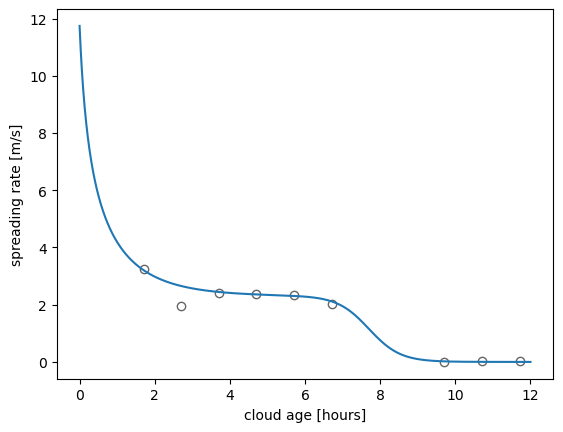

In [67]:
#first test
time = np.linspace(0., 12. * 60. * 60., 2000)
r0 = 17 * 1000.
b1 = 15. * 60.
a = 1. / (40. * 60.)
ur0 = 2.3
td = 7.7 * 60. * 60.
Delta = 50. * 60
u, r = spreading_rate_model(time, r0, b1, a, ur0, td, Delta)

plt.plot(np.mean(ages[:, :11], axis = 0), np.mean(spreading_rates[:, :], axis = 0), 'ko', alpha = 0.6, markerfacecolor = 'none')
plt.plot(time / 60. / 60., u)
plt.xlabel("cloud age [hours]")
plt.ylabel("spreading rate [m/s]")

## (3) Cloud thinning model

The last piece is a model for how $\tau_{c,SW}$ evolves. First we relate $\tau_{c,SW}$ to the cloud condensate mixing ratio $q_c$, then build a model for how $q_c$ evolves.

We assume cloud ice is evenly distributed throughout the cloud, so $IWP = q_c\rho h$, where $q_c$ is the cloud condensate mixing ratio and $\rho$ is the density of air. Substituting into the expression for $\tau_c$:
\begin{align}
\tau_c = \frac{3q_c\rho h}{2\rho_w r_e},
\end{align}
and since $h$, $\rho$, $\rho_w$ and $r_e$ are fixed, the tendency of $\tau_c$ is due solely to changes in $q_c$:
\begin{align}
\frac{d\tau_c}{dt} =
\tau_1\frac{dq_c}{dt},
\end{align}
where $\tau_1 = \frac{3\rho h}{2\rho_w r_e}$.


To obtain an evolution equation for $q_\text{c}$ we again follow [Seeley et al. (2019](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018GL080747) and consider the total water mass of the cloud: $M_\text{t} = M(q_\text{c} + q_\text{v}^*)$ where $q_\text{v}^*$ is the saturation ice mixing ratio and the cloud mass $M = \rho h \pi r^2$. The cloud gains water through entrainment of humid environmental air and loses it through microphysical removal of condensate:
\begin{align}
\frac{dM_\text{t}(t)}{dt} = \frac{dM(t)}{dt}RHq_\text{v}^* -\kappa M(t)q_\text{c}(t), 
\end{align}
where $RH$ is the environmental relative humidity over ice and $q_\text{v}^*$ is the environmental saturation ice mixing ratio, which we set equal to the in-cloud saturation mixing ratio. Both are held fixed. We use a simple Kessler-like ice aggregation scheme, with $\kappa^{-1}$ a characteristic e-folding timescale for ice removal. Expanding the left hand side gives:
\begin{align}
\frac{dM_\text{t}(t)}{dt} &= \rho h \pi\left(r(t)^2\frac{dq_\text{c}(t)}{dt} + (q_\text{c}(t) + q_\text{v}^*)\frac{dr(t)^2}{dt} \right). \notag
\end{align}
Equating the two tendencies and rearranging:
\begin{align}
\frac{dq_\text{c}(t)}{dt} &= -\left(\kappa + \frac{2u(t)}{r(t)}\right)q_\text{c}(t) - \frac{2u(t)}{r(t)}(1 - RH)q_\text{v}^*,
\end{align}
and
\begin{align}
\frac{d\tau_\text{c,SW}(t)}{dt} &= -\left(\kappa + \frac{2u(t)}{r(t)}\right)\tau_\text{c,SW}(t) - \frac{2u(t)}{r(t)}(1 - RH)q_\text{v}^*\tau_1.
\end{align}
The cloud thins as it loses water through ice aggregation (first term on the right hand side), through spreading water over a larger area (second term) and by sublimation into environmental air (third term).

Let's see how this compared to SAM:

In [68]:
#First estimate high cloud optical depth, otherwise overestimate LW CRE
r_em = data['binned ice crystal radius'].squeeze()
r_e = np.nanmean(r_em[56:73,:],axis=0)
iwp_em =data['binned iwc'].squeeze()
iwp_e = np.nansum(iwp_em[56:73,:],axis=0) #average over 10-14km
high_cod_m = 1.5 * iwp_e / 1000. / 917. / r_e / 10. ** -6 * 250.

/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/1942706534.py:3: RuntimeWarning: Mean of empty slice
  r_e = np.nanmean(r_em[56:73,:],axis=0)


In [69]:
def cloud_thinning_model(time, kappa, u, r, tau_0, qvs, RH, rho = rho_air, 
                         h = 4000, rho_ice = rho_ice, r_e = 30 * 10. ** -6.):
    """
    The cloud thinning model. Inputs:
    time = array of times [s]
    kappa = Kessler coefficient [s-1]
    u = spreading rate [m/s]
    r = cloud radius [m]
    tau_0 = initial cloud optical depth []
    qvs = environmental saturation mixing ratio [kg/kg]
    RH = environmental RH []
    rho = air density [kgm-3]
    h = cloud depth [m]
    rho_ice = ice density [kgm-3]
    r_e = effective radius [m]

    Outputs:
    tau = cloud optical depth
    """  
    
    t = len(time)
    dt = time[1] - time[0]
    tau = np.zeros(t)
    tau[0] = tau_0
    tau_1 = 3. / 2. * rho * h / rho_ice / r_e
    
    for i in range(1, t):
        qc = tau[i - 1] / tau_1
        tau[i] = tau[i - 1] - dt * (kappa + 2. * u[i - 1] / r[i - 1]) * tau[i - 1] - dt * 2. * u[i - 1] / r[i - 1] * (1. - RH) * qvs * tau_1
        if tau[i] < 0.:
            tau[i] = 0.
    return tau

In [70]:
#first rerun spreading rate model to only include time over which data are collected
t = 10000
new_time = np.linspace(1.75 * 60 * 60., max(anvil_age[8:]) * 60 * 60, t) #SAM data go from about 1.75 hours to 12 hours

b1 = 20. * 60.
a = 1. / (25. * 60.)
u2, r2 = spreading_rate_model(new_time, r0, b1, a, ur0, td, Delta)

kappa = 1. / (5. * 60. * 60.)
tau_0 = 120. #initial cloud optical depth
qvs = 10. ** -4. #environmental saturation mixing ratio
RH = 0.4 #environmental RH
tau = cloud_thinning_model(new_time, kappa, u2, r2, tau_0, qvs, RH) #high cloud optical depths

#have to adjust parameters a bit to get total cloud optical depth
tau2 = cloud_thinning_model(new_time, kappa * 1.2, u2, r2, tau_0, qvs, RH)
tau_tot = tau2 + 1.6 #1.6 = residual optical depth from lower in column

In [71]:
#Sensitivity tests
tau3 = cloud_thinning_model(new_time, 0, u2, r2, tau_0, qvs, RH) #no ice loss
tau4 = cloud_thinning_model(new_time, kappa, np.zeros(t), r2, tau_0, qvs, RH) #no spreading
tau5 = cloud_thinning_model(new_time, kappa, u2, r2, tau_0, 0., RH) #no evaporation
tau6 = cloud_thinning_model(new_time, kappa * 4.5, np.zeros(t), r2, tau_0, qvs, RH) #no spreading, faster ice loss

<>:57: SyntaxWarning: invalid escape sequence '\k'
<>:57: SyntaxWarning: invalid escape sequence '\k'
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3249432146.py:57: SyntaxWarning: invalid escape sequence '\k'
  plt.legend(["SAM", "model", "no ice loss", "no spread", "no sub", "no spread, $\kappa$ x 4.5"], fontsize = 8, loc = "lower left", ncol = 1)


1.7009385130344725


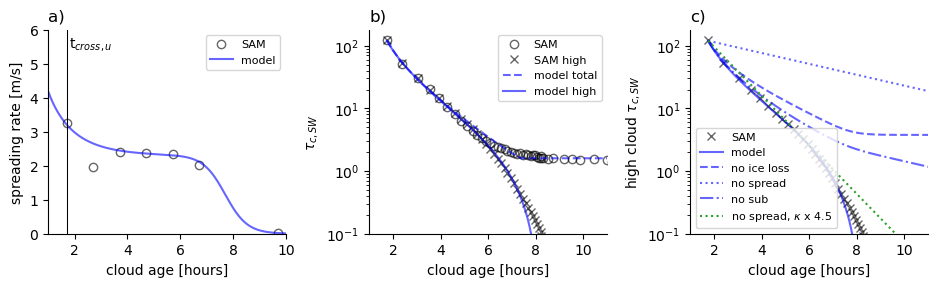

In [72]:
#######Figure 3 of main text############

fig = plt.figure(figsize = (10, 3))
plt.subplots_adjust(left = 0.07, right = 0.95, wspace = 0.35, bottom = 0.2)

ax = plt.subplot(1, 3, 1)  
plt.title("a)", loc = "left")

plt.plot(np.mean(ages[:, :11], axis = 0), np.mean(spreading_rates[:, :], axis = 0), 'ko', alpha = 0.6, markerfacecolor = 'none')
plt.xlim([1., 10.])

time = np.linspace(0., 12. * 60. * 60., 2000)

plt.plot(time / 60. / 60., u, 'b', alpha = 0.6)

t_cross = 2. / (a) * np.log(r0 * 2.5 / 2. / b1 / ur0) / 60. / 60. #cross over from KE-driven to radiatively-driven
print(t_cross)
plt.axvline( x = t_cross, color = 'k', linewidth = 0.75)
plt.text(t_cross + 0.1, 5.5, "t$_{cross, u}$")

plt.xlabel("cloud age [hours]")
plt.ylabel("spreading rate [m/s]")

plt.ylim([0., 6.])

plt.legend(["SAM", "model"], fontsize = 8)
ax.spines[['right', 'top']].set_visible(False)


ax = plt.subplot(1, 3, 2)
plt.title("b)", loc = "left")
plt.semilogy(anvil_age, cod_m, 'ko', alpha = 0.6, markerfacecolor = 'none')
plt.semilogy(anvil_age, high_cod_m, 'kx', alpha = 0.6, markerfacecolor = 'none')


plt.semilogy(new_time / 60. / 60., tau_tot, 'b--', alpha = 0.6)
plt.semilogy(new_time / 60. / 60., tau, 'b-', alpha = 0.6)

plt.legend(["SAM", "SAM high",  "model total", "model high"], fontsize = 8, loc = "upper right", ncol = 1)
plt.xlabel("cloud age [hours]")
plt.ylabel("$\\tau_{c,SW}$")
ax.spines[['right', 'top']].set_visible(False)

plt.ylim([0.1, 180.])
plt.xlim([1., 11.])

ax = plt.subplot(1, 3, 3)
plt.title("c)", loc = "left")
plt.semilogy(anvil_age, high_cod_m, 'kx', alpha = 0.6, markerfacecolor = 'none')

plt.semilogy(new_time / 60. / 60., tau, 'b', alpha = 0.6)
plt.semilogy(new_time / 60. / 60., tau3, 'b--', alpha = 0.6)
plt.semilogy(new_time / 60. / 60., tau4, 'b:', alpha = 0.6)
plt.semilogy(new_time / 60. / 60., tau5, 'b-.', alpha = 0.6)
plt.semilogy(new_time / 60. / 60., tau6, ':', color = 'tab:green', alpha = 1.)

plt.legend(["SAM", "model", "no ice loss", "no spread", "no sub", "no spread, $\kappa$ x 4.5"], fontsize = 8, loc = "lower left", ncol = 1)
plt.xlabel("cloud age [hours]")
plt.ylabel("high cloud $\\tau_{c,SW}$")
ax.spines[['right', 'top']].set_visible(False)

plt.ylim([0.1, 180.])
plt.xlim([1., 11.])

plt.savefig("images/cloud_thinning_spreading.pdf")
plt.savefig("images/cloud_thinning_spreading.png")

## Testing the model

We can now test the model. We'll do this in two ways: comparing cloudy-sky gridpoints only, and over the whole domain. To do the latter, we need to estimate the cloud fraction, $f$. $f$ can be calculated for the spreading rate model using the initial cloud radius ($r_0$) and the spreading rate.


In [73]:
#Now make CRE model, given \tau
def CRE_model(time, Qs, mu, interpolator, tau, tau_high, Tc0 = 225., lw_mu = 0.6, w = 0.12, 
              Gamma = 9.8/1000., cs_alb = 0.15, Te = 269., gamma = 1. / 2.3):
    """
    The cloud radiative effect model. Inputs:
    time = array of times [s]
    Qs = insolation [Wm-2]
    mu = cosine SW zenith angle
    interpolator = interpolation function to calculate \beta given mu
    tau = total cloud optical depth 
    tau_high = high cloud optical depth (for LW CRE)
    Tc0 = initial cloud temperature [K]
    lw_mu = cosine LW zenith angle
    w = sedimentation speed [m/s]
    Gamma = temperature lapse-rate [K/m]
    cs_alb = clear-sky albedo
    Te = environmental temperature [K}
    gamma = constant linking SW and LW optical depths


    Outputs:
    lw_cre = LW CRE [Wm-2]
    sw_cre = SW CRE [Wm-2]
    Tc = cloud temperature [K]
    """      
    t = len(time)
    dt = time[1] - time[0] # assume linear time spacing

    #cloud temperature -- linear increase as cloud sinks
    Tc = Tc0 + Gamma * w * (time - time[0])
    Tc = np.minimum(Tc, Te)

    #LW CRE from the emissivity
    emiss = (1. - np.exp(-gamma*tau_high/lw_mu))
    emiss[emiss<0.] = 0. #just to make sure
    lw_cre = emiss * sigma * (Tc ** 4 - Te ** 4)

    #Now SW CRE
    # Handle mu as scalar or time-dependent array
    mu_arr = np.asarray(mu)
    if mu_arr.ndim == 0 or mu_arr.size == 1:
        mu_used = np.full_like(tau, float(mu_arr))
    else:
        mu_used = mu_arr  # assume same length as time

    #Calculate albedos using total cloud optical depth
    # beta(mu): scalar or array
    beta_vals = interpolator(mu_arr)
    if np.ndim(beta_vals) == 0 or np.size(beta_vals) == 1:
        beta = np.full_like(tau, float(beta_vals))
    else:
        beta = beta_vals  # assume same length as time

    #Two-stream-like SW albedo: α = β τ / (μ + β τ)
    albedo = beta * tau / (mu_used + beta * tau)  
    #Calculate SW CRE
    albedo[albedo < cs_alb] = cs_alb
    
    sw_cre = Qs * (albedo - cs_alb)
    sw_cre[sw_cre < 0.] = 0.
    
    return lw_cre, sw_cre, Tc

In [74]:
#Now let's compare the CREs
#first set up average insolations and zenith angles
f = si.interp1d(anvil_age[8:], insolation_m[8:], kind='cubic')
Qs = f(new_time / 60. / 60.)
ave_mu = np.mean(Qs / 1300.)

interpolator = si.interp1d(np.asarray(mu[:]), np.asarray(beta2[:])) #interpolator to find beta for given value of mu
np.savez("data/interpolator_data.npz", mu=np.asarray(mu), beta2=np.asarray(beta2))

#Now run model
lw_cre, sw_cre, Tc = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau)
lw_cre2, sw_cre2, Tc2 = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau, w = 0.) #no ice sedimentation, constant Tc

/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3137482369.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_used = np.full_like(tau, float(mu_arr))
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3137482369.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = np.full_like(tau, float(beta_vals))


Now we want to calculate the CRE over the whole domain, so we need the cloud fractions, then multiply the CREs by these fractions. It's a bit ambiguous how to do this: do we compare the cloud in each percentile, or sum over the whole cloud at a given time? The latter gives less noisy results, so we'll use it here

In [75]:
#SAM data
total_swcre_m = np.zeros(len(cld_frac_m[8:]))
total_lwcre_m = np.zeros(len(cld_frac_m[8:]))
total_cf_m = np.zeros(len(cld_frac_m[8:]))

cf = cld_frac_m[8:]
lw = lwcre_m[8:]
sw = swcre_m[8:]

#SAM data is saved oldest -> youngest, so reverse order
cf = cf[::-1] 
lw = lw[::-1] 
sw = sw[::-1] 

total_swcre_m[0] = sw[0] * cf[0] * .02 #each bin is 1/50th of domain
total_lwcre_m[0] = lw[0] * cf[0] * .02
total_cf_m[0] = cf[0] * .02

#Sum to get CREs and cloud fraction over whole cloud at given age
for i in range(1, len(cld_frac_m[8:])):
    total_swcre_m[i] = np.sum(sw[:i + 1] * cf[:i + 1]) * .02
    total_lwcre_m[i] = np.sum(lw[:i + 1] * cf[:i + 1]) * .02
    total_cf_m[i] = np.sum(cf[:i + 1]) * 0.02
    
total_net_m = total_swcre_m + total_lwcre_m

In [76]:
#The model

#Note that when comparing with averaged data, rather than average over convection over every hour, the spreading lasts a little longer
#so recalculate spreading rates
u3, r3 = spreading_rate_model(new_time, r0, b1, a, ur0, 8.6 * 60. * 60., Delta)

#cloud fraction assuming everything is a square (matches sim. data better than circle)
cld_frac = r3 ** 2 / (128 * 1000.) ** 2

#take derivative to find increase in cloud fraction for each time-step -- this is analogous to what we can do with the SAM data
dcld_frac = np.diff(cld_frac, prepend=0)

# cumulative sums for area-averaged CREs
total_sw = np.cumsum(dcld_frac * sw_cre)
total_lw = np.cumsum(dcld_frac * lw_cre)

total_net = total_sw + total_lw

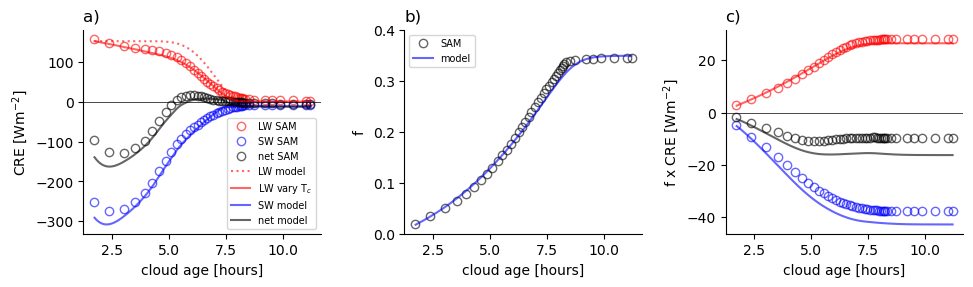

In [77]:
#######Figure 4 of main text############

fig = plt.figure(figsize = (10, 3))
plt.subplots_adjust(left = 0.07, right = 0.95, wspace = 0.35, bottom = 0.2)

ax = plt.subplot(1, 3, 1)
plt.title("a)", loc = "left")
plt.plot(anvil_age[8:], lwcre_m[8:], 'ro', markerfacecolor = 'none', alpha = 0.6)
plt.plot(anvil_age[8:], swcre_m[8:], 'bo', markerfacecolor = 'none', alpha = 0.6)
plt.plot(anvil_age[8:], lwcre_m[8:] + swcre_m[8:], 'ko', markerfacecolor = 'none', alpha = 0.6)

plt.plot(new_time / 60. / 60., -lw_cre2, 'r:', alpha = 0.6)
plt.plot(new_time / 60. / 60., -lw_cre, 'r-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -sw_cre, 'b-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -sw_cre - lw_cre, 'k-', alpha = 0.6)

plt.legend(["LW SAM", "SW SAM", "net SAM", "LW model", "LW vary T$_c$", "SW model", "net model"], loc = "lower right", ncol = 1, fontsize = 7)

ax.spines[['right', 'top']].set_visible(False)
plt.xlabel("cloud age [hours]")
plt.ylabel("CRE [Wm$^{-2}$]")
plt.axhline(y = 0., color = 'k', linewidth = 0.5)

ax = plt.subplot(1, 3, 2)
plt.title("b)", loc = "left")
plt.plot(anvil_age[8:], total_cf_m[::-1], 'ko', markerfacecolor = 'none', alpha = 0.6)

plt.plot(new_time / 60. / 60., cld_frac, 'b', alpha = 0.6)

plt.legend(["SAM", "model"], loc = "upper left", ncol = 1, fontsize = 7)

ax.spines[['right', 'top']].set_visible(False)
plt.xlabel("cloud age [hours]")
plt.ylabel("f")
plt.ylim([0., 0.4])

ax = plt.subplot(1, 3, 3)                 

plt.title("c)", loc = "left")

plt.plot(anvil_age[8:], total_lwcre_m[::-1], 'ro', markerfacecolor = 'none', alpha = 0.6)
plt.plot(anvil_age[8:], total_swcre_m[::-1], 'bo', markerfacecolor = 'none', alpha = 0.6)
plt.plot(anvil_age[8:], total_net_m[::-1], 'ko', markerfacecolor = 'none', alpha = 0.6)

plt.plot(new_time / 60. / 60., -total_lw, 'r-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -total_sw, 'b-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -total_net, 'k-', alpha = 0.6)

plt.ylabel("f x CRE [Wm$^{-2}$]")

ax.spines[['right', 'top']].set_visible(False)
plt.xlabel("cloud age [hours]")
plt.axhline(y = 0., color = 'k', linewidth = 0.5)

plt.savefig("images/final_SAM_comp.pdf")
plt.savefig("images/final_SAM_comp.png")

## Testing the model assumptions

We've made a number of assumptions in deriving the model. These are some supporting plots to justify our decisions.

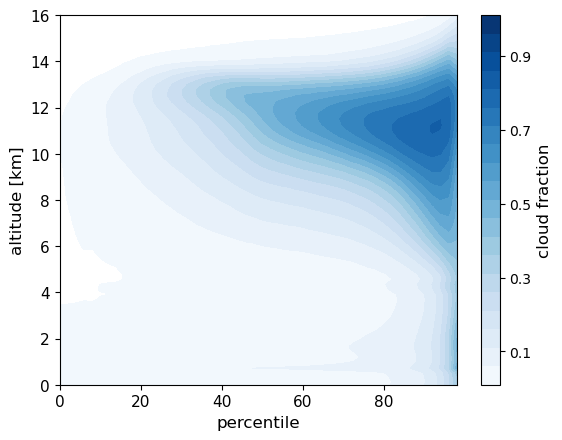

In [78]:
#######Supplementary Figure S6############

#Plot cloud fraction -- easiest to do this as a function of IWP percentile ~= cloud age
levs = np.arange(0.01, 1.05, 0.05)
plt.contourf(np.arange(0, 100, 2), data.alt / 1000., data['binned cloud fraction'], levs, cmap = plt.cm.Blues)
cmap = plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7, 0.9])
cmap.set_label("cloud fraction", fontsize = 12)
plt.ylim([0., 16.])
plt.xlabel("percentile", fontsize = 12)
plt.ylabel("altitude [km]", fontsize = 12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

plt.savefig("images/highCRE_cloud_fraction.pdf")
plt.savefig("images/highCRE_cloud_fraction.png")

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/2551847736.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$r_e$ [$\mu$m]")


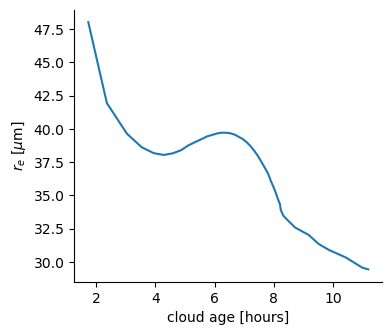

In [79]:
#######Supplementary Figure S4############

#Now look at r_e -> large changes could cause variations in \gamma
fig = plt.figure(figsize = (4, 4))
plt.subplots_adjust(left = 0.18, right = 0.95, wspace = 0.35, bottom = 0.2)

ax = plt.subplot(1, 1, 1)
#plt.title("a)", loc = "left")
plt.plot(anvil_age[8:], r_e[8:])
plt.xlabel("cloud age [hours]")
plt.ylabel("$r_e$ [$\mu$m]")
ax.spines[['right', 'top']].set_visible(False)


plt.savefig("images/re_test.pdf")
plt.savefig("images/re_test.png")

(1.0, 11.0)

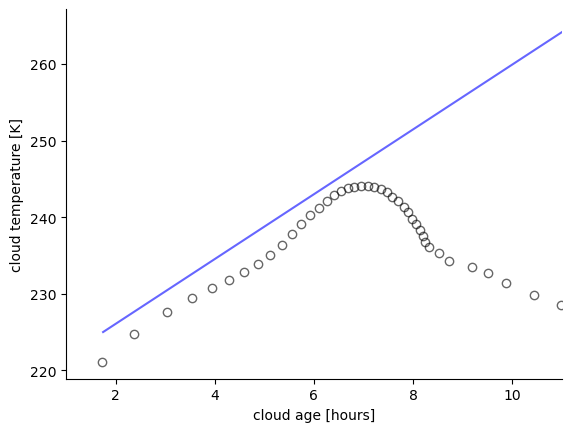

In [80]:
#Let's take a look at effective cloud emission temperatures -- how reasonable is linear assumption?
model_eps = 1. - np.exp(-high_cod_m * gamma / lw_mu)
T = (-lwcre_m[8:] / sigma / model_eps[8:] + 268. ** 4) ** 0.25

ax = plt.subplot(1, 1, 1)
plt.plot(anvil_age[8:], T, 'ko', alpha = 0.6, markerfacecolor = 'none')
plt.plot(new_time / 60. / 60., Tc, 'b', alpha = 0.6)

plt.xlabel("cloud age [hours]")
plt.ylabel("cloud temperature [K]")
ax.spines[['right', 'top']].set_visible(False)

#plt.ylim([0.1, 180.])
plt.xlim([1., 11.])

We tend to overestimate the cloud temperature late in the lifecycle, but that's fine since LW CRE is small. We also overestimate the temperature earlier. This gives a slightly smaller LW CRE over cloudy grid cells, but compensates for our spreading rates, which are a bit fast. Definitely room to optimize the model.

## Diurnal Cycle

We now look at how the model does over the diurnal cycle. Let's start by plotting the spreading rates as a function of when the convection is initiated.

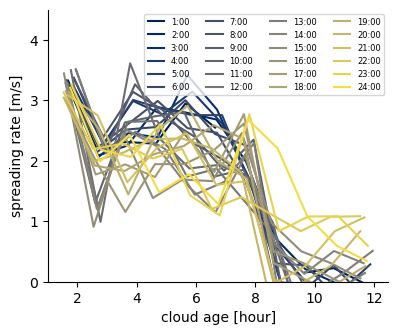

In [81]:
#######Supplementary Figure S5############

#Diurnal spreading rates
fig = plt.figure(figsize = (4, 4))
plt.subplots_adjust(left = 0.1, right = 0.95, wspace = 0.35, bottom = 0.2)

ax = plt.subplot(1, 1, 1)
for i in range(24):
    color = cmap2(i/24)  # Get color from colormap
    plt.plot(ages[i, :11], spreading_rates[i], color=color, label = str(i + 1) + ":00")

plt.legend(ncol = 4, fontsize = 6)
plt.ylim([0., 4.5])
plt.yticks([0., 1., 2., 3., 4.])
plt.xlabel("cloud age [hour]")
plt.ylabel("spreading rate [m/s]")

ax.spines[['right', 'top']].set_visible(False)

plt.savefig("images/diurnal_spreading_rates.pdf")
plt.savefig("images/diurnal_spreading_rates.png")

In [82]:
#Now grab daily CRE data
#daily_age = data['binned buoyant updraft tracer incld dc'].squeeze()
#bcu_in = np.nanmean(daily_age[:, 56:73,:],axis=1)
#daily_anvil_age=  ( np.log10(bcu_in)/np.log10(fac) ) * 4.5/3600 *fac2 #time in hours

d = 12 #Use 12 hours of data
#Convection starting at 6am
ages_6a = np.zeros(d)
ages_6a[0] = daily_anvil_age[8, -1] #First age is 1.7, so grab data at 8am
for i in range(1, d):
    ages_6a[i] = ages_6a[i - 1] + 1.
    
#Convection starting at 2pm
ages_14a = np.zeros(d)
ages_14a[0] = daily_anvil_age[16, -1] #First age is 1.7, so grab data at 4pm
for i in range(1, d):
    ages_14a[i] = ages_14a[i - 1] + 1.

#Interpolate data to higher temporal resolution
sw_cre_m = data['SW CRE hourly'].squeeze()
lw_cre_m = data['LW CRE hourly'].squeeze()

swcre_6a = np.zeros(d)
swcre_6a[0] = sw_cre_m[8, -1]
lwcre_6a = np.zeros(d)
lwcre_6a[0] = lw_cre_m[8, -1]

#manual interpolation
for i in range(1, d):
    for j in range(50):
        if daily_anvil_age[8 + i, j] > ages_6a[i] and daily_anvil_age[8 + i, j + 1] < ages_6a[i]:
            c = (ages_6a[i] - daily_anvil_age[8 + i, j + 1]) / (daily_anvil_age[8 + i, j] - daily_anvil_age[8 + i, j + 1])
            swcre_6a[i] = c * sw_cre_m[8 + i, j] + (1. - c) * sw_cre_m[8 + i, j + 1]
            lwcre_6a[i] = c * lw_cre_m[8 + i, j] + (1. - c) * lw_cre_m[8 + i, j + 1]
            break

swcre_14a = np.zeros(d)
swcre_14a[0] = sw_cre_m[16, -1]
lwcre_14a = np.zeros(d)
lwcre_14a[0] = lw_cre_m[16, -1]

for i in range(1, d):
    for j in range(50):
        if i < 8:
            if daily_anvil_age[16 + i, j] > ages_14a[i] and daily_anvil_age[16 + i, j + 1] < ages_14a[i]:
                c = (ages_14a[i] - daily_anvil_age[16 + i, j + 1]) / (daily_anvil_age[16 + i, j] - daily_anvil_age[16 + i, j + 1])
                swcre_14a[i] = c * sw_cre_m[16 + i, j] + (1. - c) * sw_cre_m[16 + i, j + 1]
                lwcre_14a[i] = c * lw_cre_m[16 + i, j] + (1. - c) * lw_cre_m[16 + i, j + 1]
                break
        else:
            if daily_anvil_age[i - 8, j] > ages_14a[i] and daily_anvil_age[i - 8, j + 1] < ages_14a[i]:
                c = (ages_14a[i] - daily_anvil_age[i - 8, j + 1]) / (daily_anvil_age[i - 8, j] - daily_anvil_age[i - 8, j + 1])
                swcre_14a[i] = c * sw_cre_m[i - 8, j] + (1. - c) * sw_cre_m[i - 8, j + 1]
                lwcre_14a[i] = c * lw_cre_m[i - 8, j] + (1. - c) * lw_cre_m[i - 8, j + 1]
                break

In [83]:
#SAM data at 6am
total_swcre_m6 = np.zeros(d)
total_lwcre_m6 = np.zeros(d)

dcld_fracs = np.zeros(12)
dcld_fracs[0] = cld_fracs[8, 0]
for i in range(1, 12):
    dcld_fracs[i] = cld_fracs[8, i] - cld_fracs[8, i - 1]

total_swcre_m6[0] = swcre_6a[0] * dcld_fracs[0] #each bin is 1/50th of domain
total_lwcre_m6[0] = lwcre_6a[0] * dcld_fracs[0]
for i in range(1, 12):
    total_swcre_m6[i] = np.sum(swcre_6a[:i + 1] * dcld_fracs[:i+1]) 
    total_lwcre_m6[i] = np.sum(lwcre_6a[:i + 1] * dcld_fracs[:i+1])

total_net_m6 = total_swcre_m6 + total_lwcre_m6

#SAM data at 2pm
total_swcre_m14 = np.zeros(d)
total_lwcre_m14 = np.zeros(d)

dcld_fracs = np.zeros(12)
dcld_fracs[0] = cld_fracs[16, 0]
for i in range(1, 12):
    dcld_fracs[i] = cld_fracs[16, i] - cld_fracs[16, i - 1]

total_swcre_m14[0] = swcre_14a[0] * dcld_fracs[0]  #each bin is 1/50th of domain
total_lwcre_m14[0] = lwcre_14a[0] * dcld_fracs[0] 
for i in range(1, 12):
    total_swcre_m14[i] = np.sum(swcre_14a[:i + 1] * dcld_fracs[:i+1]) 
    total_lwcre_m14[i] = np.sum(lwcre_14a[:i + 1] * dcld_fracs[:i+1])

total_net_m14 = total_swcre_m14 + total_lwcre_m14

In [84]:
#Now run the model for these cases
t = 10000
new_time = np.linspace(1.7 * 60 * 60., 14. * 60 * 60, t)
r0 = 17500.

#6am, assume sunrise at 6am
Qs = 1300. * np.sin(np.pi * new_time / 60. / 60. / 12.)
Qs[Qs < 0.] = 0.
theta = -np.pi / 2. + new_time / 60. / 60.  * np.pi / 12.
mu = np.cos(theta)
mu[mu < 0.001] = 0.001

u6, r6 = spreading_rate_model(new_time, r0, b1, a, ur0, td, Delta)
tau6 = cloud_thinning_model(new_time, kappa, u6, r6, tau_0, qvs, RH) #high cloud optical depths
tau_tot6 = cloud_thinning_model(new_time, kappa * 1.5, u6, r6, tau_0, qvs, RH) + 1.6 #high cloud optical depths
lw_cre_6, sw_cre_6, Tc_6 = CRE_model(new_time, Qs, mu, interpolator, tau_tot6, tau6)

#2pm, assume sunrise at 6am
Qs = 1300. * np.sin(np.pi * (10. + (new_time - new_time[0]) / 60. / 60.) / 12.)
Qs[Qs < 0.] = 0.

theta = -np.pi / 2. + (10. + (new_time - new_time[0]) / 60. / 60.) / 12.
mu = np.cos(theta)
mu[mu < 0.001] = 0.001

u14, r14 = spreading_rate_model(new_time, r0 * .75, b1, a, ur0 * .8, 7. * 60 * 60., Delta)
tau14 = cloud_thinning_model(new_time, kappa, u14, r14, tau_0, qvs, RH) #high cloud optical depths
tau_tot14 = cloud_thinning_model(new_time, kappa * 1.5, u14, r14, tau_0, qvs, RH) + 2.2 #high cloud optical depths
lw_cre_14, sw_cre_14, Tc_14 = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot14, tau14)

/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3137482369.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_used = np.full_like(tau, float(mu_arr))
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3137482369.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = np.full_like(tau, float(beta_vals))


In [85]:
#Estimate total CRE

#cloud fraction assuming everything is a square (matches sim. data better than circle)
cld_frac = r6 ** 2 / sim_area

#take derivative to find increase in cloud fraction for each time-step -- this is more analogous to SAM data
dcld_frac = np.diff(cld_frac, prepend=0)

# cumulative sums for area-averaged CREs
total_sw6 = np.cumsum(dcld_frac * sw_cre_6)
total_lw6 = np.cumsum(dcld_frac * lw_cre_6)

total_net6 = total_sw6 + total_lw6

cld_frac = r14 ** 2 / sim_area

#take derivative to find increase in cloud fraction for each time-step -- this is more analogous to SAM data
dcld_frac = np.diff(cld_frac, prepend=0)

# cumulative sums for area-averaged CREs
total_sw14 = np.cumsum(dcld_frac * sw_cre_14)
total_lw14 = np.cumsum(dcld_frac * lw_cre_14)

total_net14 = total_sw14 + total_lw14

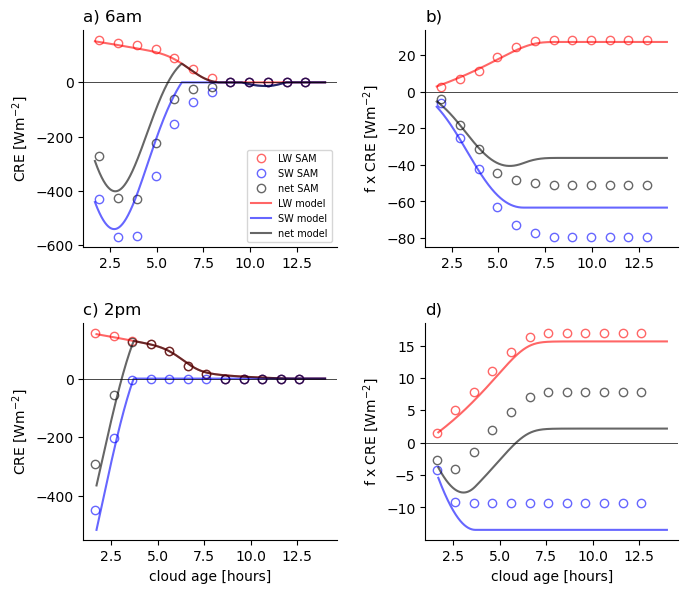

In [86]:
#######Supplementary Figure S7############

#CREs at 6am and 2pm
fig = plt.figure(figsize = (7, 6))
plt.subplots_adjust(left = 0.1, right = 0.95, wspace = 0.35, hspace = 0.35, bottom = 0.1, top = 0.95)

ax = plt.subplot(2, 2, 1)
plt.title("a) 6am", loc = "left")
plt.plot(ages_6a, lwcre_6a, 'ro', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_6a, swcre_6a, 'bo', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_6a, lwcre_6a + swcre_6a, 'ko', markerfacecolor = 'none', alpha = 0.6)

plt.plot(new_time / 60. / 60., -lw_cre_6, 'r-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -sw_cre_6, 'b-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -sw_cre_6 - lw_cre_6, 'k-', alpha = 0.6)

plt.legend(["LW SAM", "SW SAM", "net SAM", "LW model", "SW model", "net model"], loc = "lower right", ncol = 1, fontsize = 7)

ax.spines[['right', 'top']].set_visible(False)
#plt.xlabel("cloud age [hours]")
plt.ylabel("CRE [Wm$^{-2}$]")
plt.axhline(y = 0., color = 'k', linewidth = 0.5)

ax = plt.subplot(2, 2, 2)
plt.title("b)", loc = "left")
plt.plot(ages_6a, total_lwcre_m6, 'ro', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_6a, total_swcre_m6, 'bo', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_6a, total_lwcre_m6 + total_swcre_m6, 'ko', markerfacecolor = 'none', alpha = 0.6)

plt.plot(new_time / 60. / 60., -total_lw6, 'r-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -total_sw6, 'b-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -total_sw6 - total_lw6, 'k-', alpha = 0.6)

#plt.legend(["LW SAM", "SW SAM", "net SAM", "LW model", "SW model", "net model"], loc = "lower right", ncol = 1, fontsize = 7)

ax.spines[['right', 'top']].set_visible(False)
#plt.xlabel("cloud age [hours]")
plt.ylabel("f x CRE [Wm$^{-2}$]")
plt.axhline(y = 0., color = 'k', linewidth = 0.5)


ax = plt.subplot(2, 2, 3)
plt.title("c) 2pm", loc = "left")
plt.plot(ages_14a, lwcre_14a, 'ro', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_14a, swcre_14a, 'bo', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_14a, lwcre_14a + swcre_14a, 'ko', markerfacecolor = 'none', alpha = 0.6)

plt.plot(new_time / 60. / 60., -lw_cre_14, 'r-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -sw_cre_14, 'b-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -sw_cre_14 - lw_cre_14, 'k-', alpha = 0.6)

#plt.legend(["LW SAM", "SW SAM", "net SAM", "LW model", "SW model", "net model"], loc = "lower right", ncol = 1, fontsize = 7)

ax.spines[['right', 'top']].set_visible(False)
plt.xlabel("cloud age [hours]")
plt.ylabel("CRE [Wm$^{-2}$]")
plt.axhline(y = 0., color = 'k', linewidth = 0.5)

ax = plt.subplot(2, 2, 4)
plt.title("d)", loc = "left")
plt.plot(ages_14a, total_lwcre_m14, 'ro', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_14a, total_swcre_m14, 'bo', markerfacecolor = 'none', alpha = 0.6)
plt.plot(ages_14a, total_lwcre_m14 + total_swcre_m14, 'ko', markerfacecolor = 'none', alpha = 0.6)

plt.plot(new_time / 60. / 60., -total_lw14, 'r-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -total_sw14, 'b-', alpha = 0.6)
plt.plot(new_time / 60. / 60., -total_sw14 - total_lw14, 'k-', alpha = 0.6)

#plt.legend(["LW SAM", "SW SAM", "net SAM", "LW model", "SW model", "net model"], loc = "lower right", ncol = 1, fontsize = 7)

ax.spines[['right', 'top']].set_visible(False)
plt.xlabel("cloud age [hours]")
plt.ylabel("f x CRE [Wm$^{-2}$]")
plt.axhline(y = 0., color = 'k', linewidth = 0.5)

plt.savefig("images/SAM_comp_6am2pm.png")
plt.savefig("images/SAM_comp_6am2pm.pdf")

## Sensitivity Tests

Interesting parameters we can vary:
* Tc (cloud temperature)
* Qs (insolation)
* r$_0$ (initial cloud radius)
* $\tau_0$ (initial cloud optical depth)
* b$^{-1}$ (initial doubling time)
* a (KE decay rate)
* u$_\text{R0}$ (radiatively-driven spreading rate)
* $\kappa$ (ice removal rate)
* w (sedimentation speed)
* RH (environmental RH)
* qv* (environmental saturation mixing ratio)
* time of convective initiation

In [87]:
#Cycle through the parameters.

#First set up radiative parameters to make sure we haven't overwritten the values we want
mu = np.cos(ds.SZA[:] * np.pi / 180.) #cosine SW zenith angles
t = 10000
new_time = np.linspace(1.75 * 60 * 60., max(anvil_age[8:]) * 60 * 60, t)
#first set up average insolations and zenith angles
f = si.interp1d(anvil_age[8:], insolation_m[8:], kind='cubic')
Qs = f(new_time / 60. / 60.)
ave_mu = np.mean(Qs / 1300.)

interpolator = si.interp1d(np.asarray(mu[:]), np.asarray(beta2[:])) #interpolator to find beta for given value of mu

#Other parameters
Tc0 = 225.
r0 = 17000.
tau0 = 120.
b1 = 20. * 60.
a = 1. / (25. * 60.)
ur0 = 2.3
kappa = 1. / (5. * 60. * 60.)
w = 0.12
qvs = 10. ** -4.
RH = 0.4
td = 8.6 * 60. * 60.

#vary parameters by 2%
perc = [1.02, 0.98]
overcast_CRE = np.zeros( ( 12, 2))
total_CRE = np.zeros( ( 12, 2 ) )

for i in range(12):
        if i < 5:
            #parameters related to spreading
            if i == 0:
                #control
                u, r = spreading_rate_model(new_time, r0 , b1, a, ur0, td, Delta)
                u2, r2 = spreading_rate_model(new_time, r0, b1, a, ur0, td, Delta)
            if i == 1:
                #vary initial radius
                u, r = spreading_rate_model(new_time, r0 * perc[0], b1, a, ur0, td, Delta)
                u2, r2 = spreading_rate_model(new_time, r0 * perc[1], b1, a, ur0, td, Delta)
            if i == 2:
                #vary b^-1
                u, r = spreading_rate_model(new_time, r0, b1 * perc[0], a, ur0, td, Delta)
                u2, r2 = spreading_rate_model(new_time, r0, b1 * perc[1], a, ur0, td, Delta)
            if i == 3:
                #vary a
                u, r = spreading_rate_model(new_time, r0, b1, a * perc[0], ur0, td, Delta)
                u2, r2 = spreading_rate_model(new_time, r0, b1, a * perc[1], ur0, td, Delta)
            if i == 4:
                #vary ur0
                u, r = spreading_rate_model(new_time, r0, b1, a, ur0 * perc[0], td, Delta)
                u2, r2 = spreading_rate_model(new_time, r0, b1, a, ur0 * perc[1], td, Delta)

            #now get cloud optical depths            
            tau = cloud_thinning_model(new_time, kappa, u, r, tau_0, qvs, RH) 
            tau_tot = cloud_thinning_model(new_time, kappa * 1.2, u, r, tau_0, qvs, RH) + 1.6 
            tau2 = cloud_thinning_model(new_time, kappa, u2, r2, tau_0, qvs, RH) 
            tau_tot2 = cloud_thinning_model(new_time, kappa * 1.2, u2, r2, tau_0, qvs, RH) + 1.6

            #calculate CREs:
            lw_cre, sw_cre, Tc = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau, Tc0 = Tc0)
            lw_cre2, sw_cre2, Tc2 = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot2, tau2, Tc0 = Tc0)
            
        else:
            #now vary parameters related to radiation and microphysics
            u, r = spreading_rate_model(new_time, r0, b1, a, ur0, td, Delta)
            u2, r2 = spreading_rate_model(new_time, r0, b1, a, ur0, td, Delta)

            #cloud microphysics parameters
            if i == 5:
                #vary kappa
                tau = cloud_thinning_model(new_time, kappa * perc[0], u, r, tau_0, qvs, RH)
                tau_tot = cloud_thinning_model(new_time, kappa * 1.2 * perc[0], u, r, tau_0, qvs, RH) + 1.6 
                tau2 = cloud_thinning_model(new_time, kappa * perc[1], u2, r2, tau_0, qvs, RH) 
                tau_tot2 = cloud_thinning_model(new_time, kappa * 1.2 * perc[1], u2, r2, tau_0, qvs, RH) + 1.6 
            if i == 6:
                #vary qv*
                tau = cloud_thinning_model(new_time, kappa, u, r, tau_0, qvs * perc[0], RH) 
                tau_tot = cloud_thinning_model(new_time, kappa * 1.2, u, r, tau_0, qvs * perc[0], RH) + 1.6 
                tau2 = cloud_thinning_model(new_time, kappa, u2, r2, tau_0, qvs * perc[1], RH) 
                tau_tot2 = cloud_thinning_model(new_time, kappa * 1.2, u2, r2, tau_0, qvs * perc[1], RH) + 1.6 
            if i == 7:
                #vary RH
                tau = cloud_thinning_model(new_time, kappa, u, r, tau_0, qvs, RH * perc[0]) 
                tau_tot = cloud_thinning_model(new_time, kappa * 1.2, u, r, tau_0, qvs, RH * perc[0]) + 1.6 
                tau2 = cloud_thinning_model(new_time, kappa, u2, r2, tau_0, qvs, RH * perc[1]) 
                tau_tot2 = cloud_thinning_model(new_time, kappa * 1.2, u2, r2, tau_0, qvs, RH * perc[1]) + 1.6 
            if i == 8:
                #vary initial cloud optical depth
                tau = cloud_thinning_model(new_time, kappa, u, r, tau_0 * perc[0], qvs, RH) 
                tau_tot = cloud_thinning_model(new_time, kappa * 1.2, u, r, tau_0 * perc[0], qvs, RH) + 1.6  
                tau2 = cloud_thinning_model(new_time, kappa, u2, r2, tau_0 * perc[1], qvs, RH)
                tau_tot2 = cloud_thinning_model(new_time, kappa * 1.2, u2, r2, tau_0* perc[1], qvs, RH ) + 1.6 
                
            #cloud radiation
            if i > 8:
                tau = cloud_thinning_model(new_time, kappa, u, r, tau_0, qvs, RH) 
                tau_tot = cloud_thinning_model(new_time, kappa * 1.2, u, r, tau_0, qvs, RH) + 1.6 
                
                if i == 9:
                    #vary Qs
                    lw_cre, sw_cre, Tc = CRE_model(new_time, Qs * perc[0], [ave_mu], interpolator, tau_tot, tau)
                    lw_cre2, sw_cre2, Tc2 = CRE_model(new_time, Qs * perc[1], [ave_mu], interpolator, tau_tot, tau)
                elif i == 10:
                    #vary cloud temperature
                    lw_cre, sw_cre, Tc = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau, Tc0 = Tc0 * perc[0])
                    lw_cre2, sw_cre2, Tc2 = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau, Tc0 = Tc0 * perc[1])
                elif i == 11:
                    #vary sedimentation rate
                    lw_cre, sw_cre, Tc = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau, w = w * perc[0])
                    lw_cre2, sw_cre2, Tc2 = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau, w = w * perc[1])
            else:
                lw_cre, sw_cre, Tc = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot, tau)
                lw_cre2, sw_cre2, Tc2 = CRE_model(new_time, Qs, [ave_mu], interpolator, tau_tot2, tau2)

        #Now calculate CREs over whole domain
        #cloud fraction assuming everything is a square (matches sim. data better than circle)
        cld_frac = r ** 2 / sim_area
        cld_frac2 = r2 ** 2 / sim_area
        
        #take derivative to find increase in cloud fraction for each time-step -- this is more analogous to SAM data
        dcld_frac = np.diff(cld_frac, prepend=0)
    
        # cumulative sums for area-averaged CREs
        total_sw = np.cumsum(dcld_frac * sw_cre)
        total_lw = np.cumsum(dcld_frac * lw_cre)
                
        total_net = total_sw + total_lw
        
        overcast_CRE[i, 0] = np.trapz(lw_cre + sw_cre, new_time) / (max(new_time) - min(new_time))
        total_CRE[i, 0] = total_net[-1]

        #take derivative to find increase in cloud fraction for each time-step -- this is more analogous to SAM data
        dcld_frac = np.diff(cld_frac, prepend=0)

        # cumulative sums for area-averaged CREs
        total_sw = np.cumsum(dcld_frac * sw_cre2)
        total_lw = np.cumsum(dcld_frac * lw_cre2)
        
        total_net2 = total_sw + total_lw
        
        overcast_CRE[i, 1] = np.trapz(lw_cre2 + sw_cre2, new_time) / (max(new_time) - min(new_time))
        total_CRE[i, 1] = total_net2[-1]


/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3137482369.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_used = np.full_like(tau, float(mu_arr))
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/3137482369.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta = np.full_like(tau, float(beta_vals))


In [88]:
def interp_cre_for_hour(row_idx, target_age, daily_anvil_age, sw_cre_m, lw_cre_m):
    """
    Interpolate SW and LW CRE at a given anvil age for a specific hour (row).

    Assumes daily_anvil_age[row] is monotonically decreasing in percentile index.
    """
    ages_row = daily_anvil_age[row_idx]   # shape (nbins,)
    sw_row   = sw_cre_m[row_idx]
    lw_row   = lw_cre_m[row_idx]

    # Reverse ages to increasing order for searchsorted
    ages_rev = ages_row[::-1]
    idx_rev = np.searchsorted(ages_rev, target_age, side="left")
    k = len(ages_row) - idx_rev - 1       # ages_row[k] >= target_age >= ages_row[k+1]
    k = np.clip(k, 0, len(ages_row) - 2)  # guard edges

    # Linear interpolation
    num = target_age - ages_row[k + 1]
    den = ages_row[k] - ages_row[k + 1]
    c = num / den

    sw = c * sw_row[k] + (1.0 - c) * sw_row[k + 1]
    lw = c * lw_row[k] + (1.0 - c) * lw_row[k + 1]
    return sw, lw

In [89]:
#Now do diurnal cycle. First grab CRM data
cre_time = np.zeros( 24 )
frac_cre_time = np.zeros( 24 )

day = np.arange(0, 12, 1)
d = 12
for k in range(24):
    # cloud ages for convection initiated at hour k
    ages = daily_anvil_age[k, -1] + np.arange(d)

    swcre_a = np.zeros(d)
    lwcre_a = np.zeros(d)

    # first point: take last percentile bin directly at initiation hour
    swcre_a[0] = sw_cre_m[k, -1]
    lwcre_a[0] = lw_cre_m[k, -1]

    # rows wrap around the diurnal cycle (this replaces your s / if/else logic)
    rows = (k + np.arange(d)) % 24
    
    for i in range(1, d):
        row = rows[i]
        swcre_a[i], lwcre_a[i] = interp_cre_for_hour(
            row, ages[i], daily_anvil_age, sw_cre_m, lw_cre_m
        ) 
  
    # time-mean net CRE for this start hour
    net = swcre_a + lwcre_a
    cre_time[k] = np.trapz(net, day) / d
    
    cld_frac_row = cld_fracs[k, :d]              # cloud fraction time series for this start hour
    dcld = np.diff(cld_frac_row, prepend=0)      # incremental cloud fraction at each step

    total_sw_a = np.cumsum(dcld * swcre_a)
    total_lw_a = np.cumsum(dcld * lwcre_a)
    total_net_a = total_sw_a + total_lw_a

    frac_cre_time[k] = total_net_a[-1]

In [90]:
#Run the model with different start times, note we don't vary the spreading rate
model_cre_time = np.zeros(24)
model_frac_cre_time = np.zeros(24)

cld_frac = r2 ** 2 / (128 * 1000.) ** 2

#take derivative to find increase in cloud fraction for each time-step -- this is more analogous to SAM data
dcld_frac = np.diff(cld_frac, prepend=0)

for j in range( 24 ):
    Qs = 1300. * np.sin(np.pi * (float(j) + (new_time - new_time[0]) / 60. / 60.) / 12.)
    Qs[Qs < 0.] = 0.

    theta = -np.pi / 2. + (float(j) + (new_time - new_time[0]) / 60. / 60.) / 12. * np.pi
    mu = np.cos(theta)
    mu[mu < 0.001] = 0.001

    u, r = spreading_rate_model(new_time, r0, b1, a, ur0* perc[0], td, Delta)
    tau = cloud_thinning_model(new_time, kappa, u, r, tau_0, qvs, RH) 
    tau_tot = cloud_thinning_model(new_time, kappa * 1.2, u, r, tau_0, qvs, RH) + 1.6 
    lw_cre_t, sw_cre_t, Tc = CRE_model(new_time, Qs, mu, interpolator, tau_tot, tau)

    net = lw_cre_t + sw_cre_t

    model_cre_time[j] = np.trapz(net, new_time) / (max(new_time) - min(new_time))

    # cumulative sums for area-averaged CRE
    total_swt = np.cumsum(dcld_frac * sw_cre_t)
    total_lwt = np.cumsum(dcld_frac * lw_cre_t)
        
    model_frac_cre_time[j] = total_swt[-1] + total_lwt[-1]

model_cre_time = np.roll(model_cre_time, 6)
model_frac_cre_time = np.roll(model_frac_cre_time, 5)

In [91]:
#Sort by highest CRE sensitivity: 
overcast_diff = np.zeros( 11 )
overcast_diff[0] = abs(overcast_CRE[10, 1] - overcast_CRE[10, 0])
overcast_diff[1] = abs(overcast_CRE[9, 1] - overcast_CRE[9, 0])
overcast_diff[2] = abs(overcast_CRE[4, 1] - overcast_CRE[4, 0])
overcast_diff[3] = abs(overcast_CRE[8, 1] - overcast_CRE[8, 0])
overcast_diff[4] = abs(overcast_CRE[1, 1] - overcast_CRE[1, 0])
overcast_diff[5] = abs(overcast_CRE[5, 1] - overcast_CRE[5, 0])
overcast_diff[6] = abs(overcast_CRE[6, 1] - overcast_CRE[6, 0])
overcast_diff[7] = abs(overcast_CRE[-1, 1] - overcast_CRE[-1, 0])
overcast_diff[8] = abs(overcast_CRE[7, 1] - overcast_CRE[7, 0])
overcast_diff[9] = abs(overcast_CRE[3, 1] - overcast_CRE[3, 0])
overcast_diff[10] = abs(overcast_CRE[2, 1] - overcast_CRE[2, 0])

total_diff = np.zeros( 11 )
total_diff[0] = abs(total_CRE[10, 1] - total_CRE[10, 0])
total_diff[1] = abs(total_CRE[9, 1] - total_CRE[9, 0])
total_diff[2] = abs(total_CRE[4, 1] - total_CRE[4, 0])
total_diff[3] = abs(total_CRE[8, 1] - total_CRE[8, 0])
total_diff[4] = abs(total_CRE[1, 1] - total_CRE[1, 0])
total_diff[5] = abs(total_CRE[5, 1] - total_CRE[5, 0])
total_diff[6] = abs(total_CRE[6, 1] - total_CRE[6, 0])
total_diff[7] = abs(total_CRE[-1, 1] - total_CRE[-1, 0])
total_diff[8] = abs(total_CRE[7, 1] - total_CRE[7, 0])
total_diff[9] = abs(total_CRE[3, 1] - total_CRE[3, 0])
total_diff[10] = abs(total_CRE[2, 1] - total_CRE[2, 0])

xlabels = ["T$_c$", "Q$_s$", "u$_{r0}$", "$\\tau_0$", "$r_0$", "$\kappa$", "$q_v^*$", "w", "RH", "$a$", "$b$"]


<>:28: SyntaxWarning: invalid escape sequence '\k'
<>:28: SyntaxWarning: invalid escape sequence '\k'
/var/folders/pl/qxvqb44d2m1gb2gxb4dpwk440000gn/T/ipykernel_90046/437950457.py:28: SyntaxWarning: invalid escape sequence '\k'
  xlabels = ["T$_c$", "Q$_s$", "u$_{r0}$", "$\\tau_0$", "$r_0$", "$\kappa$", "$q_v^*$", "w", "RH", "$a$", "$b$"]


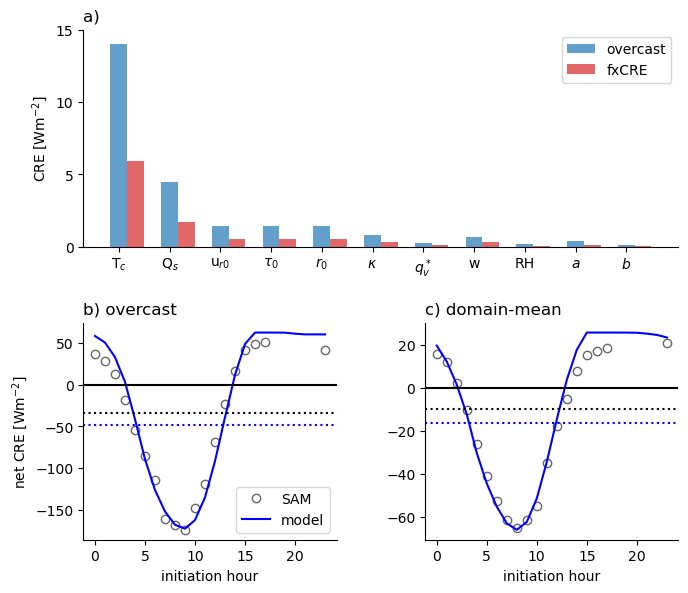

In [92]:
#######Figure 5 of main text############

fig = plt.figure(figsize = (7, 6))
plt.subplots_adjust(left = 0.1, right = 0.95, wspace = 0.35, hspace = 0.35, bottom = 0.1, top = 0.95)

ax = plt.subplot(2, 1, 1)
plt.title("a)", loc = "left", fontsize = 12)

xs = np.arange(1, 12, 1)

plt.bar(xs, overcast_diff, width = 0.33, color = 'tab:blue', alpha = 0.7)
plt.bar(xs + 0.33, total_diff, width = 0.33, color = 'tab:red', alpha = 0.7)

plt.yticks([0., 5., 10., 15.])
plt.xticks(xs, xlabels, fontsize = 10)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel("CRE [Wm$^{-2}$]", fontsize = 10)

plt.legend(["overcast", "fxCRE"])

ax = plt.subplot(2, 2, 3)
plt.title("b) overcast", loc = "left", fontsize = 12)

day = np.arange(0, 24, 1)
plt.plot(day, np.roll(cre_time, -2), 'ko', markerfacecolor = 'none', alpha = 0.6)
plt.plot(day, -np.roll(model_cre_time, -2), '-', color = 'b')
plt.axhline(y = 0., color = 'k')

net_m = swcre_m[8:] + lwcre_m[8:]
cre_m = np.trapz(net_m, anvil_age[8:]) / (max(anvil_age[8:]) - min(anvil_age[8:]))
plt.axhline(y = -cre_m, color = 'k', linestyle = ':')
plt.axhline(y = -overcast_CRE[0,0], color = 'b', linestyle = ':')

ax.spines[['right', 'top']].set_visible(False)
plt.legend(["SAM", "model"], fontsize = 10)
plt.xlabel("initiation hour", fontsize = 10)
plt.ylabel("net CRE [Wm$^{-2}$]", fontsize = 10)

ax = plt.subplot(2, 2, 4)
plt.title("c) domain-mean", loc = "left", fontsize = 12)

day = np.arange(0, 24, 1)
plt.plot(day, np.roll(frac_cre_time, -2), 'ko', markerfacecolor = 'none', alpha = 0.6)
plt.plot(day, -np.roll(model_frac_cre_time, -2), '-', color = 'b')
plt.axhline(y = 0., color = 'k')

plt.axhline(y = total_net_m[-1], color = 'k', linestyle = ':')
plt.axhline(y = -total_CRE[0, 0], color = 'b', linestyle = ':')

ax.spines[['right', 'top']].set_visible(False)
#plt.legend(["SAM", "model"])
plt.xlabel("initiation hour", fontsize = 10)
#plt.ylabel("net CRE [Wm$^{-2}$]", fontsize = 12)

plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.savefig("images/sensitivity_tests.pdf")
plt.savefig("images/sensitivity_tests.png")